In [40]:
import pandas as pd 
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import power_anova 

In [41]:
data = pd.read_csv('PTSD_filtered.csv')

#to create a varaible for age at sefla and consequently create a binary varaiable for young or not
data['dob'] = pd.to_datetime(data['dob'])
data['date'] = pd.to_datetime(data['date'])
data['age_at_sefla'] = None

for idx, row in data.iterrows():
    if row['day'] == 'sefla':
        data.at[idx, 'age_at_sefla'] = (row['date'] - row['dob']).days / 7
    else:
        sefla_row = data[(data['cohort_id'] == row['cohort_id']) & (data['day'] == 'sefla')]
        if not sefla_row.empty:
            data.at[idx, 'age_at_sefla'] = sefla_row.iloc[0]['age_at_sefla']

data['young'] = data['age_at_sefla'] < 12

/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_7664/4145871084.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['dob'] = pd.to_datetime(data['dob'])
/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_7664/4145871084.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


In [73]:
#take out the sefla stage for better comparison between groups 
subset_data = data[data['day'] != 'sefla']
experimental_group = subset_data[subset_data['condition'] == 'sefl']
control_group = subset_data[subset_data['condition'] == 'control']

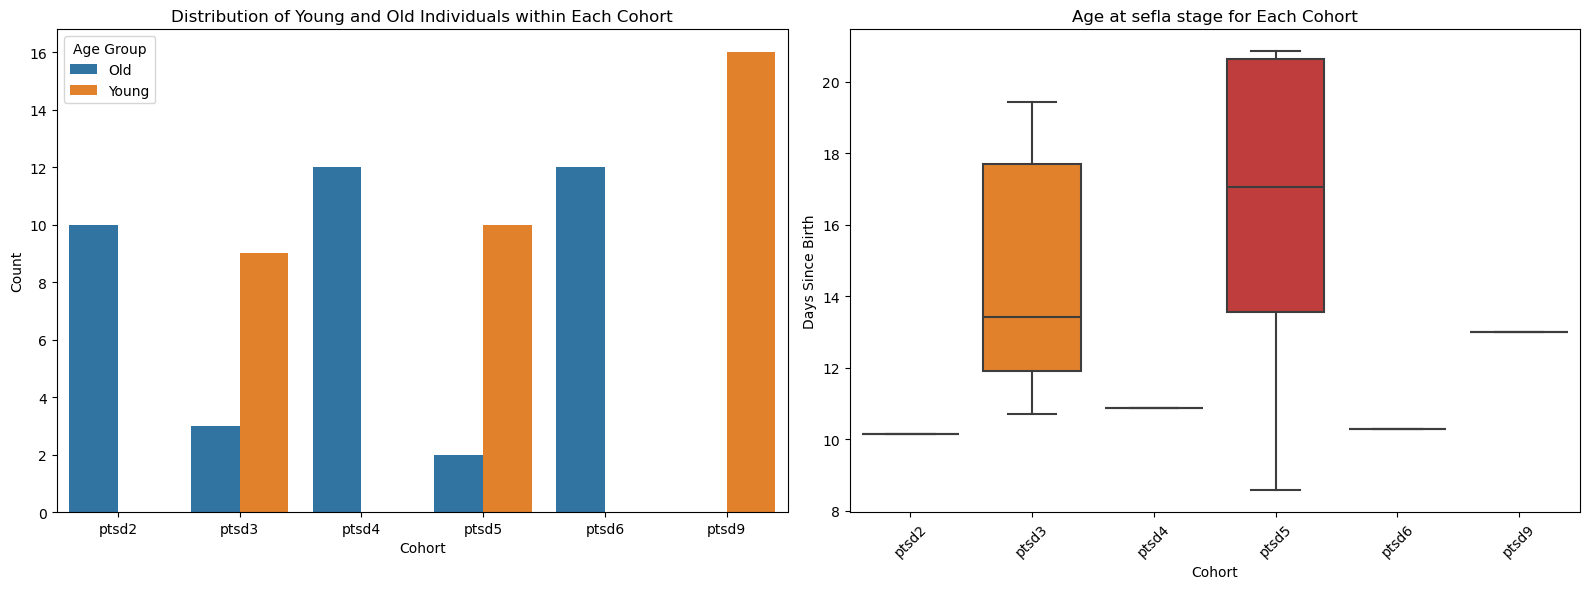

In [88]:
data_grouped = data.groupby('cohort_id').first().reset_index()

# Convert 'young' column to string type for plotting
data_grouped['young'] = data_grouped['young'].astype(str)

plt.figure(figsize=(16, 6))  

# Plot 1: Distribution of Young and Old Individuals within Each Cohort
plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and select the first plot
sns.countplot(data=data_grouped, x='cohort', hue='young', order=sorted(data_grouped['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Count')
plt.title('Distribution of Young and Old Individuals within Each Cohort')
plt.legend(title='Age Group', labels=['Old', 'Young'])

# Plot 2: Days Since Birth for Each Cohort
plt.subplot(1, 2, 2)
sns.boxplot(data=data_grouped, x='cohort', y='age_at_sefla', order=sorted(data_grouped['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Days Since Birth')
plt.title('Age at sefla stage for Each Cohort')
plt.xticks(rotation=45)  
plt.tight_layout()  

In [45]:
#wrangle the data for wide format 
wrangled_data = subset_data.pivot(index='cohort_id', columns='day', values='freezing')
wrangled_data = wrangled_data.merge(subset_data[['condition', 'sex', 'cohort', 'young', 'cohort_id']].drop_duplicates('cohort_id'), on='cohort_id', how='left')
column_sequence = ['cohort_id', 'condition', 'seflb', 'recall1', 'recall2', 'recall3', 'recall4', 'recall5', 'sex', 'young', 'cohort']
wrangled_data = wrangled_data[column_sequence]
print(wrangled_data[wrangled_data['condition']=='sefl']['young'].value_counts())
print(wrangled_data[wrangled_data['condition']=='control']['young'].value_counts())
print(wrangled_data[wrangled_data['condition']=='sefl']['sex'].value_counts())
print(wrangled_data[wrangled_data['condition']=='control']['sex'].value_counts())


young
True     24
False    22
Name: count, dtype: int64
young
True     15
False    13
Name: count, dtype: int64
sex
male      30
female    16
Name: count, dtype: int64
sex
male      20
female     8
Name: count, dtype: int64


In [46]:
# ANOVA on freezing time between young and not young within experimental group
experimental_model_young = pg.mixed_anova(data=experimental_group, dv='freezing', within='day', between='young', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Experimental Group between Young vs Not Young:")
print(experimental_model_young)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=experimental_model_young['np2'].iloc[0], k=2, power=0.80))


# ANOVA on freezing time between young and not young within control group
control_model_young = pg.mixed_anova(data=control_group, dv='freezing', within='day', between='young', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Control Group between Young vs Not Young:")
print(control_model_young)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=control_model_young['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time within Experimental Group between Young vs Not Young:
        Source            SS  DF1  DF2            MS          F         p-unc  \
0        young  11291.815359    1   36  11291.815359  19.938267  7.599005e-05   
1          day  13777.082332    5  180   2755.416466  19.814018  1.035909e-15   
2  Interaction   1060.623298    5  180    212.124660   1.525374  1.840129e-01   

      p-GG-corr       np2       eps sphericity   W-spher  p-spher  
0           NaN  0.356433       NaN        NaN       NaN      NaN  
1  1.072362e-11  0.355001  0.708188      False  0.392938  0.00315  
2           NaN  0.040649       NaN        NaN       NaN      NaN  
The required sample size per group n: 8.1676
repeated ANOVA for Freezing Time within Control Group between Young vs Not Young:
        Source           SS  DF1  DF2           MS         F         p-unc  \
0        young  1833.886047    1   17  1833.886047  7.716583  1.289142e-02   
1          day  2725.716225    5 

/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_7664/1880026480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experimental_group['young'] = experimental_group['young'].astype(str)
/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_7664/1880026480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group['young'] = control_group['young'].astype(str)


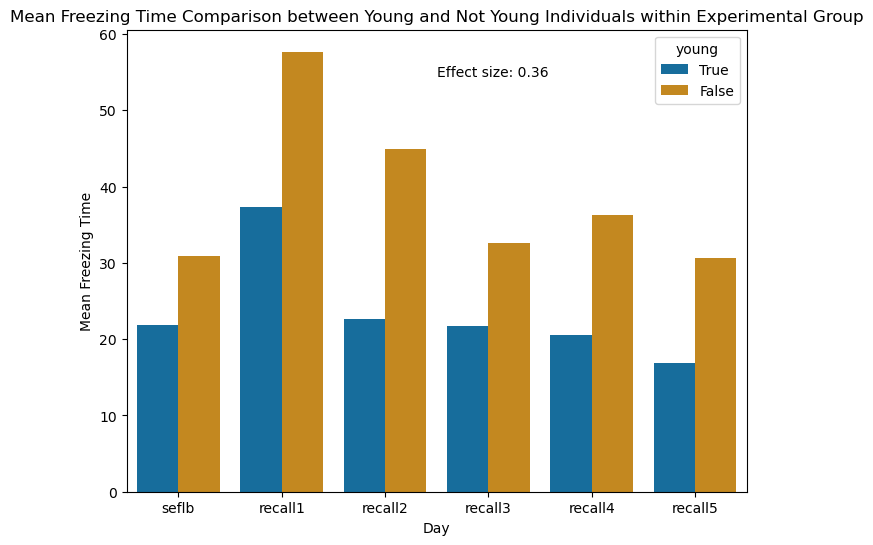

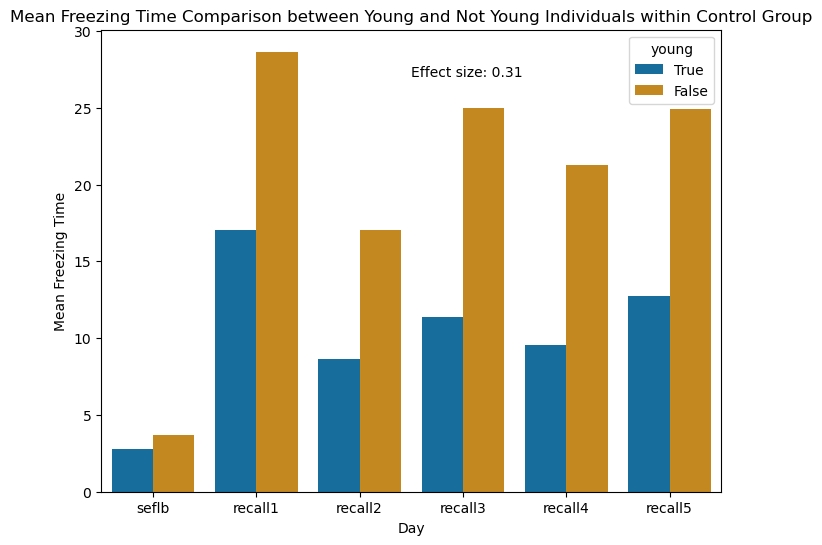

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


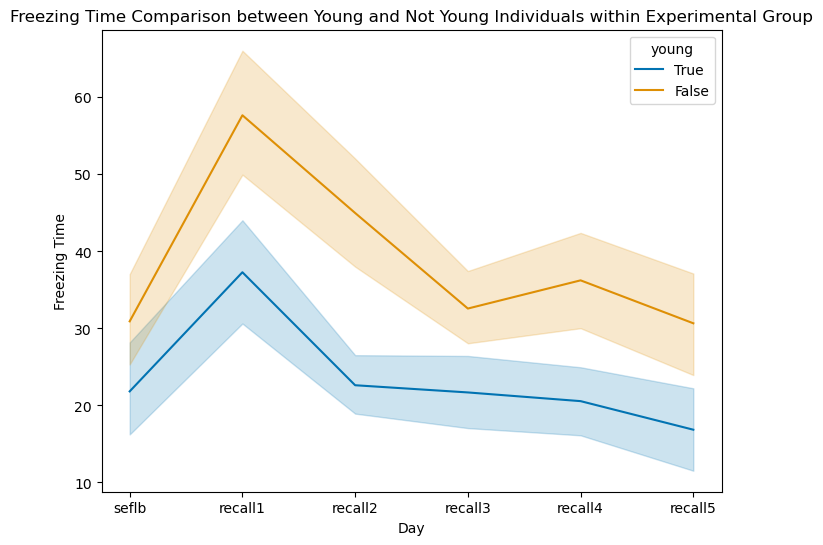

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


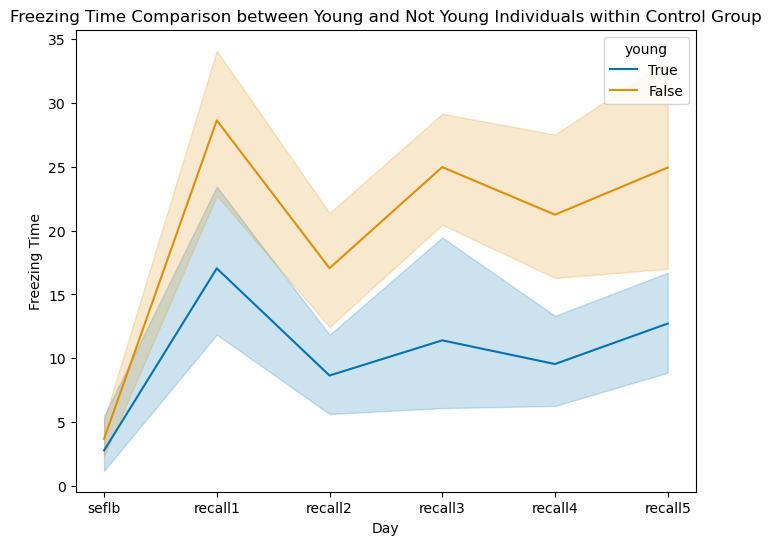

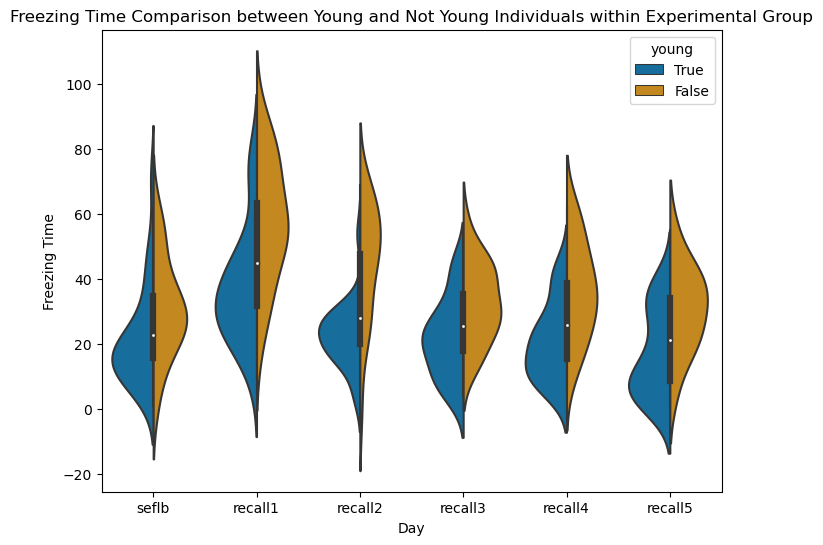

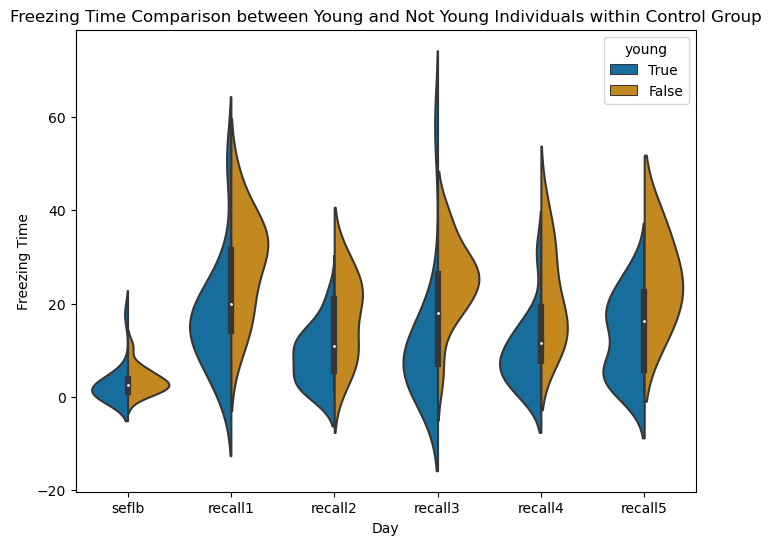

In [91]:
experimental_group['young'] = experimental_group['young'].astype(str)
control_group['young'] = control_group['young'].astype(str)

plt.figure(figsize=(8, 6))
sns.barplot(data=experimental_group, x='day', y='freezing', hue='young', palette="colorblind", errorbar=None)
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time Comparison between Young and Not Young Individuals within Experimental Group')
experimental_young_effect_size = experimental_model_young['np2'].iloc[0]
plt.text(0.5, 0.9, f"Effect size: {experimental_young_effect_size:.2f}", transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(data=control_group, x='day', y='freezing', hue='young', palette="colorblind", errorbar=None)
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time Comparison between Young and Not Young Individuals within Control Group')
control_young_effect_size = control_model_young['np2'].iloc[0]
plt.text(0.5, 0.9, f"Effect size: {control_young_effect_size:.2f}", transform=plt.gca().transAxes)
plt.show()


plt.figure(figsize=(8, 6))
sns.lineplot(data=experimental_group, x='day', y='freezing', hue='young', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Young and Not Young Individuals within Experimental Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=control_group, x='day', y='freezing', hue='young', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Young and Not Young Individuals within Control Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=experimental_group, x='day', y='freezing', hue='young', palette="colorblind", split=True)
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Young and Not Young Individuals within Experimental Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=control_group, x='day', y='freezing', hue='young', palette="colorblind", split=True)
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Young and Not Young Individuals within Control Group')
plt.show()


In [48]:
# ANOVA on freezing time between sex within experimental group
experimental_model_sex = pg.mixed_anova(data=experimental_group, dv='freezing', within='day', between='sex', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Experimental Group between male vs female:")
print(experimental_model_sex)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=experimental_model_sex['np2'].iloc[0], k=2, power=0.80))

# ANOVA on freezing time between sex within control group
control_model_sex = pg.mixed_anova(data=control_group, dv='freezing', within='day', between='sex', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Control Group between male vs female:")
print(control_model_sex)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=control_model_sex['np2'].iloc[0], k=2, power=0.80))

repeated ANOVA for Freezing Time within Experimental Group between male vs female:
        Source            SS  DF1  DF2           MS          F         p-unc  \
0          sex   2638.188259    1   36  2638.188259   3.270276  7.890522e-02   
1          day  13777.082332    5  180  2755.416466  20.760484  2.381910e-16   
2  Interaction   2201.805317    5  180   440.361063   3.317868  6.845019e-03   

      p-GG-corr       np2       eps sphericity   W-spher  p-spher  
0           NaN  0.083276       NaN        NaN       NaN      NaN  
1  1.072362e-11  0.365756  0.708188      False  0.392938  0.00315  
2           NaN  0.084386       NaN        NaN       NaN      NaN  
The required sample size per group n: 44.1823
repeated ANOVA for Freezing Time within Control Group between male vs female:
        Source           SS  DF1  DF2          MS         F         p-unc  \
0          sex   382.153509    1   17  382.153509  1.182950  2.919367e-01   
1          day  2725.716225    5   85  545.143

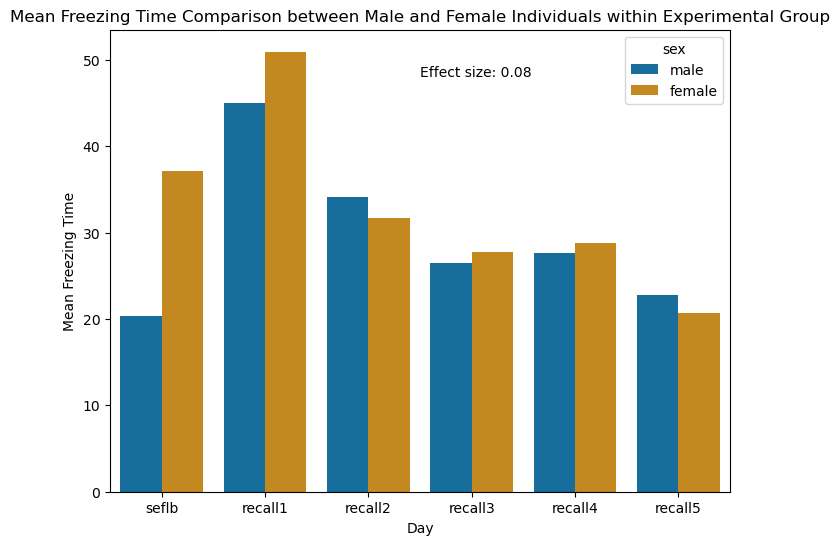

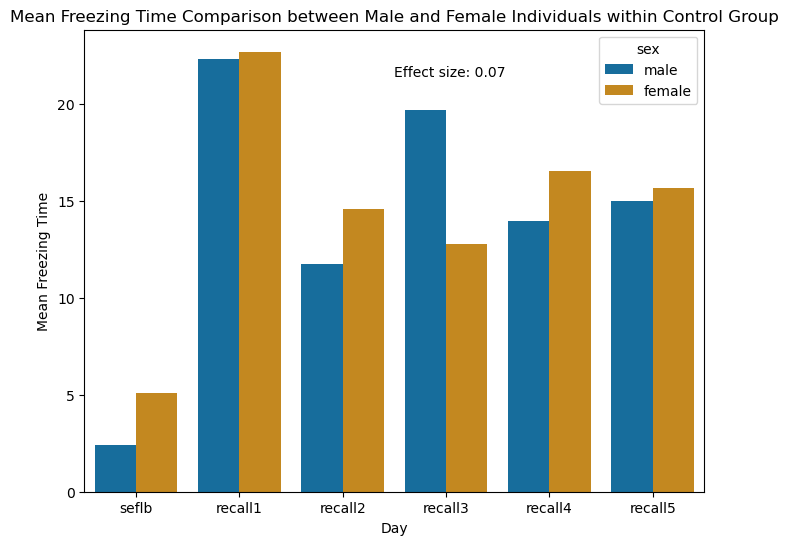

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


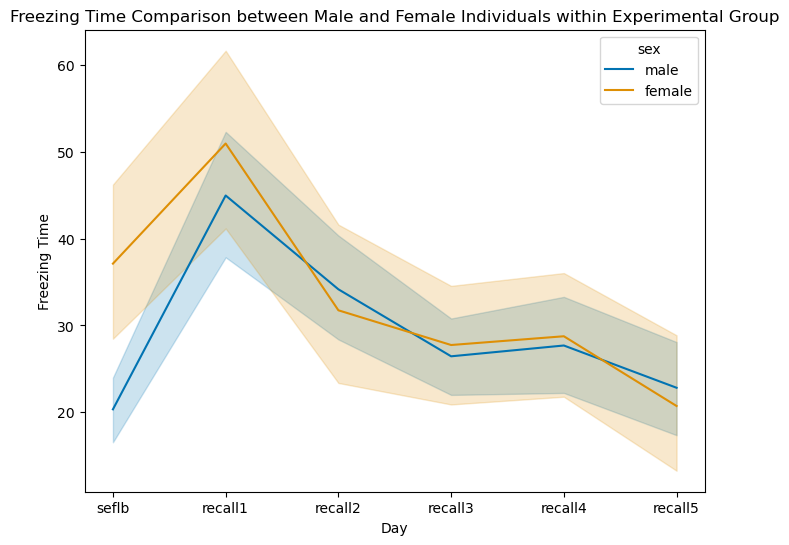

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


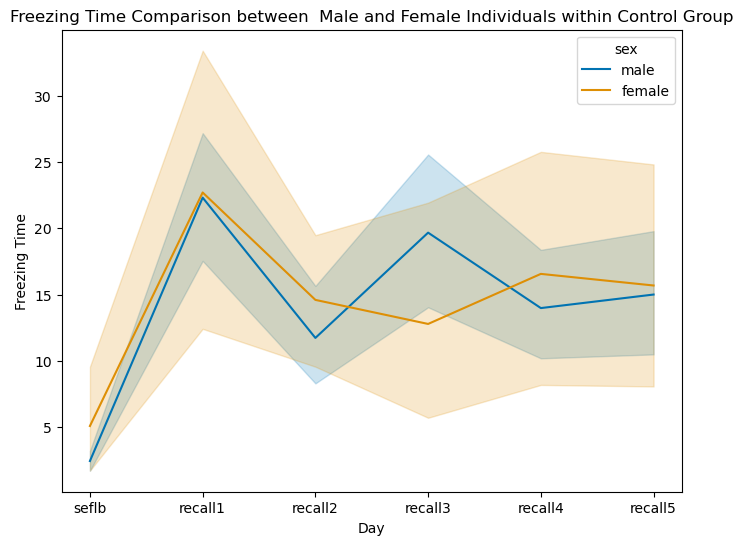

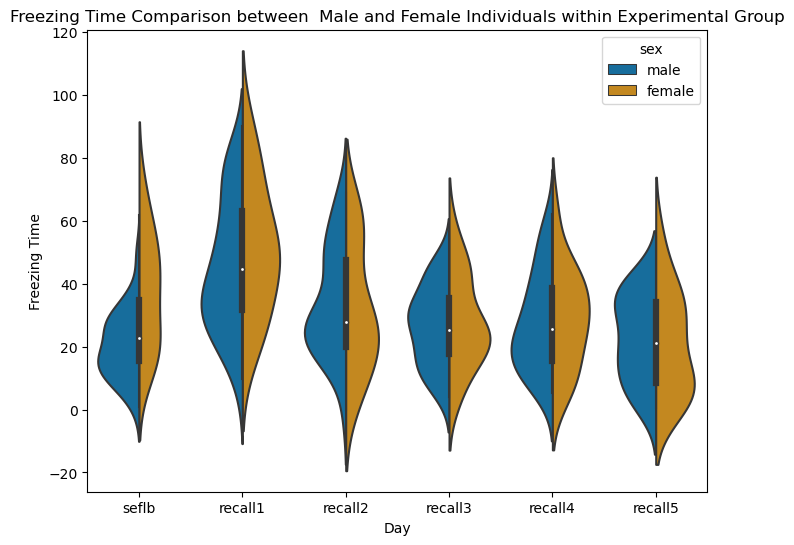

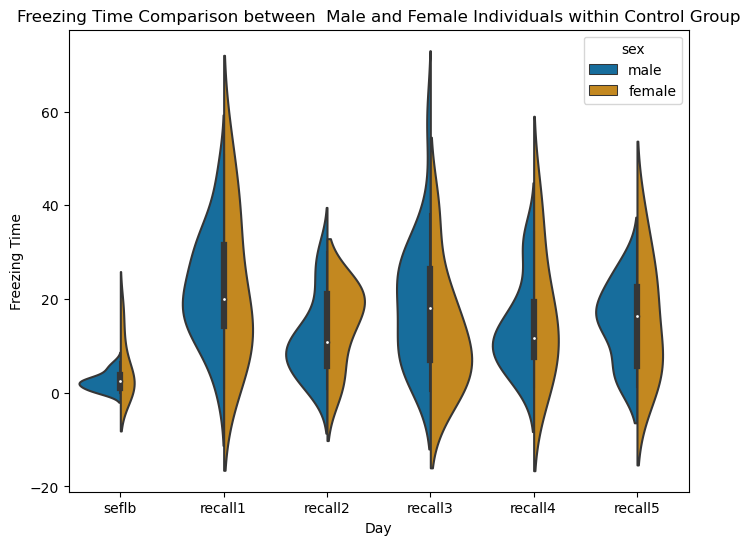

In [92]:
plt.figure(figsize=(8, 6))
sns.barplot(data=experimental_group, x='day', y='freezing', hue='sex', palette="colorblind", errorbar=None)
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time Comparison between Male and Female Individuals within Experimental Group')
experimental_sex_effect_size = experimental_model_sex['np2'].iloc[0]
plt.text(0.5, 0.9, f"Effect size: {experimental_sex_effect_size:.2f}", transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(data=control_group, x='day', y='freezing', hue='sex', palette="colorblind", errorbar=None)
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time Comparison between Male and Female Individuals within Control Group')
control_sex_effect_size = control_model_sex['np2'].iloc[0]
plt.text(0.5, 0.9, f"Effect size: {control_sex_effect_size:.2f}", transform=plt.gca().transAxes)
plt.show()


plt.figure(figsize=(8, 6))
sns.lineplot(data=experimental_group, x='day', y='freezing', hue='sex', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Male and Female Individuals within Experimental Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=control_group, x='day', y='freezing', hue='sex', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between  Male and Female Individuals within Control Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=experimental_group, x='day', y='freezing', hue='sex', palette="colorblind", split=True)
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between  Male and Female Individuals within Experimental Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=control_group, x='day', y='freezing', hue='sex', palette="colorblind", split=True)
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between  Male and Female Individuals within Control Group')
plt.show()


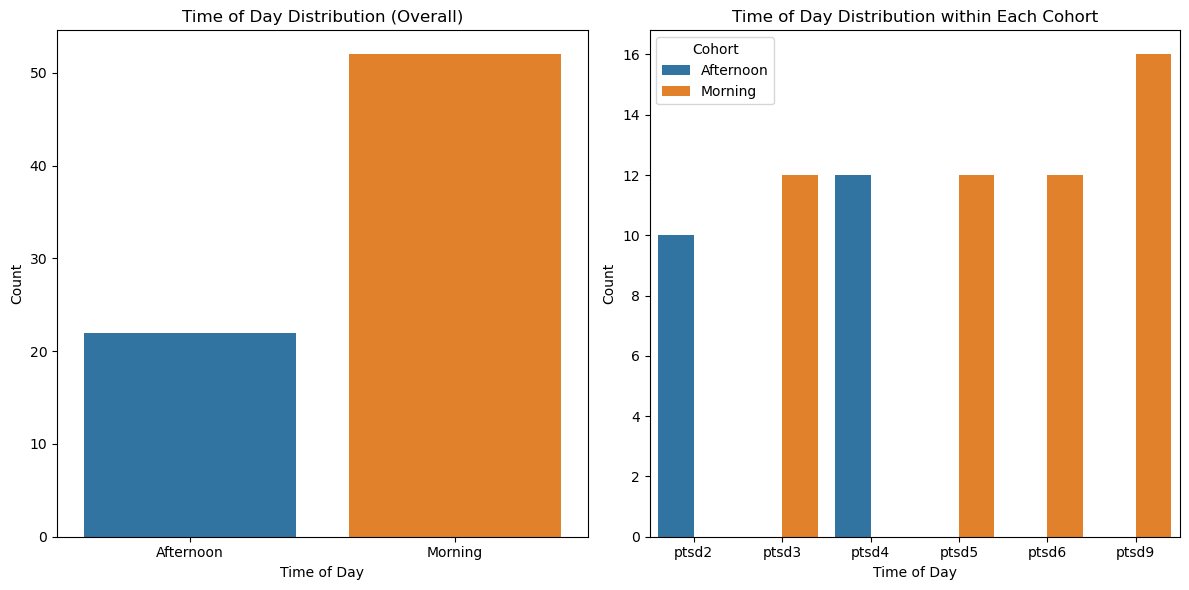

In [50]:
data_grouped_2 = subset_data.groupby('cohort_id').first().reset_index()
data_grouped_2['time_of_day'] = data_grouped_2['time_of_day'].astype(str)  # Convert boolean values to strings

# Overall time of day distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=data_grouped_2, x='time_of_day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution (Overall)')

# Time of day distribution within each cohort
plt.subplot(1, 2, 2)
sns.countplot(data=data_grouped_2, x='cohort', hue='time_of_day', order=sorted(data_grouped_2['cohort'].unique()))
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution within Each Cohort')
plt.legend(title='Cohort')

plt.tight_layout()
plt.show()



In [96]:
# this is the part that I am not sure about
# all four ways are to create the same variable in different ways, it should be similar to what I did for the 'young' variable. However, I'm not sure why it keeps giving me a value error in the code chuck below when there is no missing data. 
data['time_in_day'] = [x[-2:] for x in data['time']]
data['AM'] = data['time_in_day'] == 'AM'
data['time_of_day'] = data['time'].apply(lambda x: True if x.endswith('AM') else False)
data['time_of_day'] = data['time_of_day'].map({True: 'Morning', False: 'Afternoon'})

subset_data = data[data['day'] != 'sefla']
experimental_group = subset_data[subset_data['condition'] == 'sefl']
control_group = subset_data[subset_data['condition'] == 'control']

In [80]:
# ANOVA on freezing time between morning and afternoon within experimental group
experimental_model_time_of_day = pg.mixed_anova(data=experimental_group, dv='freezing', within='day', between='AM', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Experimental Group between Morning vs Afternoon:")
print(experimental_model_time_of_day)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=experimental_model_time_of_day['np2'].iloc[0], k=2, power=0.80))


# ANOVA on freezing time between young and not young within control group
control_model_time_of_day = pg.mixed_anova(data=control_group, dv='freezing', within='day', between='AM', subject='cohort_id', effsize="np2")
print("repeated ANOVA for Freezing Time within Control Group between Morning vs Afternoon:")
print(control_model_time_of_day)
print('The required sample size per group n: %.4f' % power_anova(eta_squared=control_model_time_of_day['np2'].iloc[0], k=2, power=0.80))



ValueError: cannot convert float NaN to integer

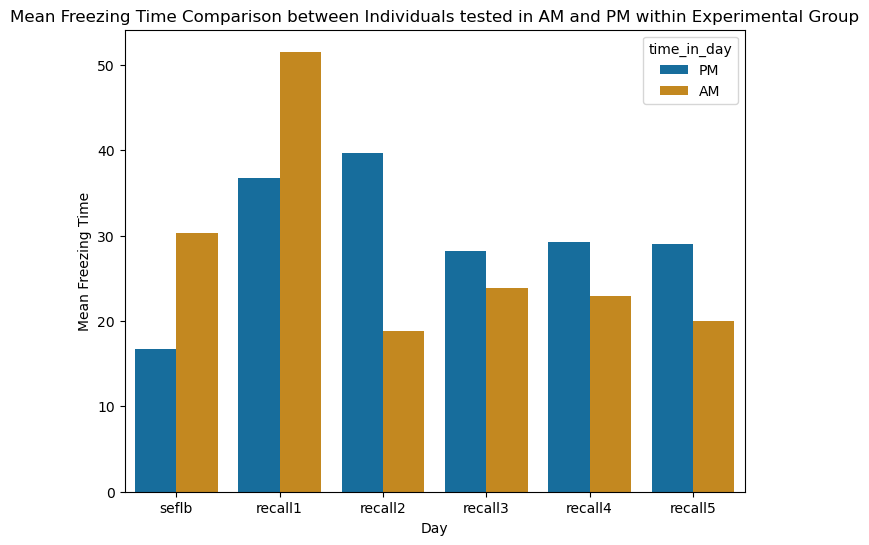

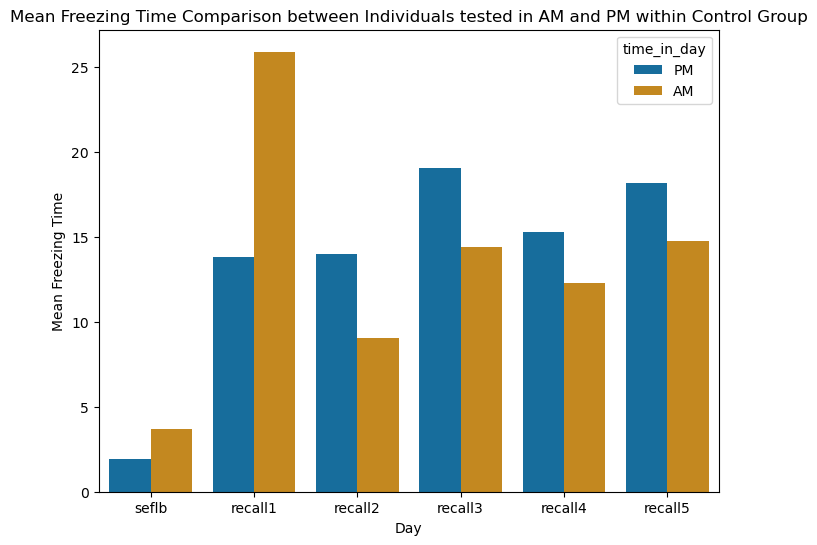

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


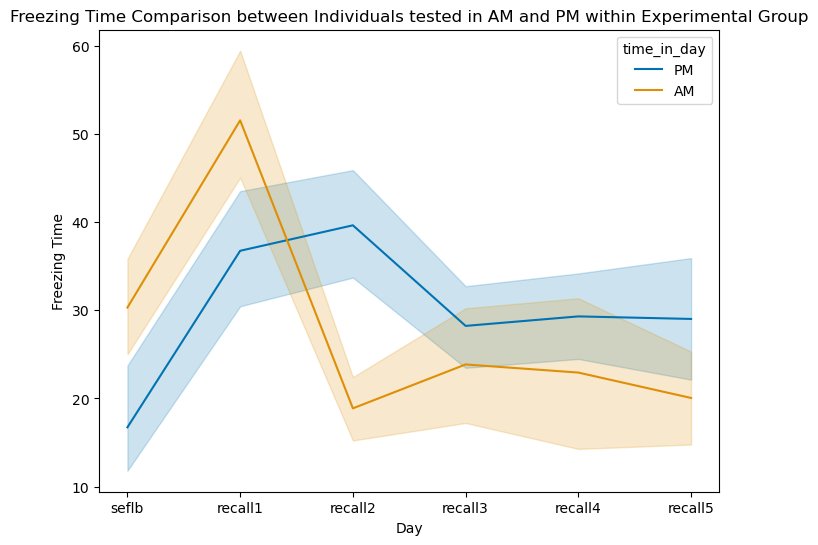

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


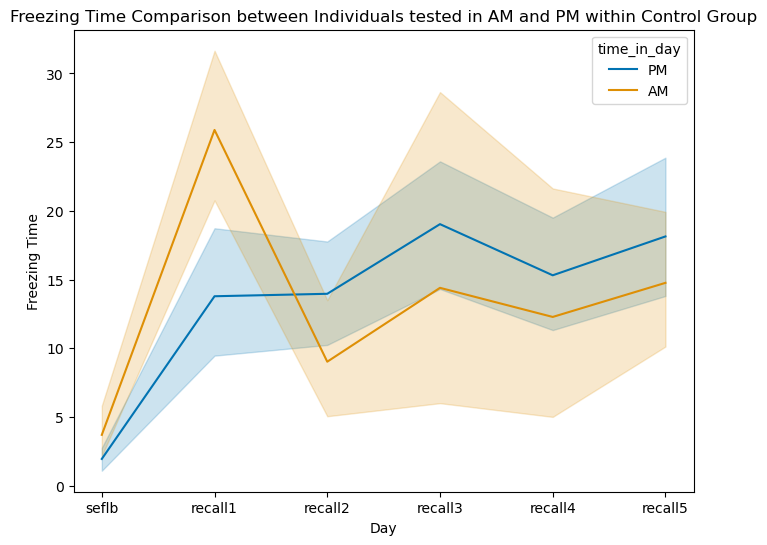

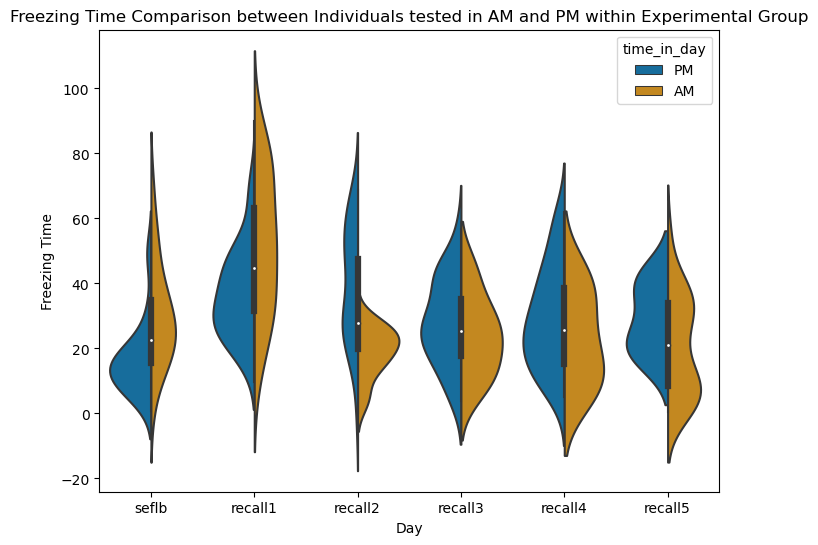

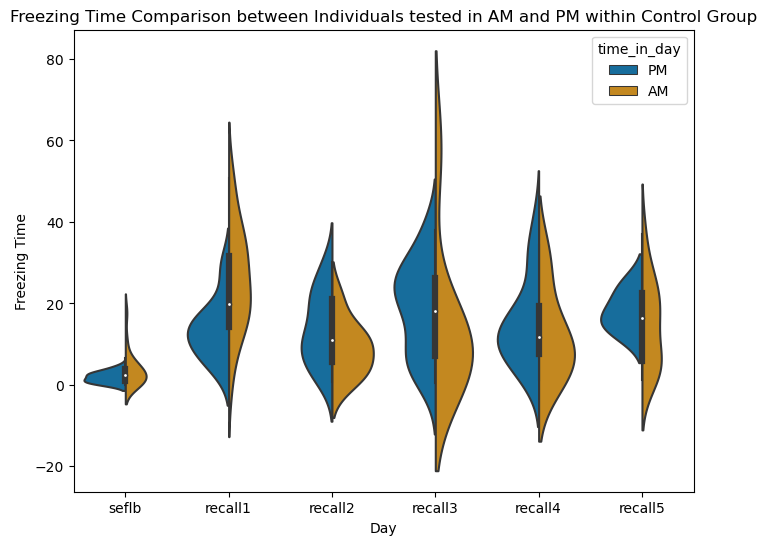

In [97]:
plt.figure(figsize=(8, 6))
sns.barplot(data=experimental_group, x='day', y='freezing', hue='time_in_day', palette="colorblind", errorbar=None)
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time Comparison between Individuals tested in AM and PM within Experimental Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(data=control_group, x='day', y='freezing', hue='time_in_day', palette="colorblind", errorbar=None)
plt.xlabel('Day')
plt.ylabel('Mean Freezing Time')
plt.title('Mean Freezing Time Comparison between Individuals tested in AM and PM within Control Group')
plt.show()


plt.figure(figsize=(8, 6))
sns.lineplot(data=experimental_group, x='day', y='freezing', hue='time_in_day', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Individuals tested in AM and PM within Experimental Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(data=control_group, x='day', y='freezing', hue='time_in_day', palette="colorblind")
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Individuals tested in AM and PM within Control Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=experimental_group, x='day', y='freezing', hue='time_in_day', palette="colorblind", split=True)
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Individuals tested in AM and PM within Experimental Group')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=control_group, x='day', y='freezing', hue='time_in_day', palette="colorblind", split=True)
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Individuals tested in AM and PM within Control Group')
plt.show()
